# Abstract Network
This notebook aims to evaluate an entire abstracted network. 
At the end, some pruning trial will be performed.

In [7]:


%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('../util')
import torch
import torch.nn as nn


from abstractModule import AbstractReLU as AR
from abstractModule import AbstractMaxpool2D as AM
from abstractWeight import AbstractWeight as AW
from abstractNN import AbstractNN as NN
from custom_train import CustomTrainer as CT
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os

import numpy as np
device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


# The network
We are still working on our simple CNN network for benchmark.
The forward abstract method is implemented with abstractNN method. 
abstractNN.abstract_linear takes in input a nn.Sequential(nn.Flatten, nn.Linear), an abstract tensor, and two tupple of index/values for abstraction of weight and bias. 


In [5]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(4608,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
     
        x=self.maxpool(x)
     
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,
                         conv1_eps_weight,
                         conv1_eps_bias,
                         conv2_eps_weight,
                         conv2_eps_bias,
                         fc1_eps_weight,
                         fc1_eps_bias, 
                         fc2_eps_weight,
                         fc2_eps_bias,
                         add_symbol=False,
                         device=torch.device("cpu")):
        self.device=device
        AR.max_symbol = np.inf
        AM.max_symbol = np.inf
        AR.recycling = 1
        AM.recycling =1 
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)
      
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv1,x,x_true,conv1_eps_weight , conv1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
   
        symb_1 = len(x)
       
        x,x_min,x_max,x_true = NN.abstract_conv2D(self.conv2,x,x_true,conv2_eps_weight,conv2_eps_bias,device=self.device)
       
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
      
        x,x_min,x_max ,x_true = AM.abstract_maxpool2D(self.maxpool,x,x_true,add_symbol=add_symbol,device=self.device)
    
      
        symb_conv2 =len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc1,x,x_true,fc1_eps_weight,fc1_eps_bias,device=self.device)
     
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
  
  
        symb_fc1 = len(x)
        x,x_min,x_max,x_true = NN.abstract_linear(self.fc2,x,x_true,fc2_eps_weight,fc2_eps_bias,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        
        
        return x,x_min,x_max,x_true,symb_1,symb_conv2, symb_fc1
        

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[1310]
plt.imshow(1-img[0],cmap='gray')
print(f"Label:{label}")
img.shape
from abstract import abstractTensor as AT

x=AT(img,alpha =torch.tensor([]))
x=x.abstract_tensor()
x.shape

In [ ]:
model = AbstractNN()

Here you can read an example how to generate tupples for weight and bias abstraction
Some methods need to be implement

In [ ]:
scale = 0.0001
conv1_eps_weight = torch.tensor([])
conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
conv1_eps_weight.values = scale*(1)*torch.ones_like(conv1_eps_weight.indices)
conv1_eps_bias = torch.tensor([])
conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
conv1_eps_bias.values = scale*(1)*torch.ones_like(conv1_eps_bias.indices)


conv2_eps_weight = torch.tensor([])
conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
conv2_eps_weight.values = scale*(1)*torch.ones_like(conv2_eps_weight.indices)
conv2_eps_bias = torch.tensor([])
conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
conv2_eps_bias.values = scale*(1)*torch.ones_like(conv2_eps_bias.indices)

fc1_eps_weight = torch.tensor([])
fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
fc1_eps_weight.values = scale*(1)*torch.ones_like(fc1_eps_weight.indices)
fc1_eps_bias = torch.tensor([])
fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
fc1_eps_bias.values = scale*(1)*torch.ones_like(fc1_eps_bias.indices)


fc2_eps_weight = torch.tensor([])
fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
fc2_eps_weight.values = scale*(1)*torch.ones_like(fc2_eps_weight.indices)
fc2_eps_bias = torch.tensor([])
fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
fc2_eps_bias.values = scale*(1)*torch.ones_like(fc2_eps_bias.indices)

In [ ]:
model = AbstractNN()

In [ ]:
with torch.no_grad():

   result,x_min,x_max,x_true,_,_,_=model_assesment.abstract_forward(x,
                                                    conv1_eps_bias=conv1_eps_bias,
                                                    conv1_eps_weight=conv1_eps_weight,
                                                    conv2_eps_weight = conv2_eps_weight,
                                                    conv2_eps_bias = conv2_eps_bias,
                                                    fc1_eps_weight =fc1_eps_weight,
                                                    fc1_eps_bias = fc1_eps_bias, 
                                                    fc2_eps_weight = fc2_eps_weight,
                                                    fc2_eps_bias = fc2_eps_bias,

                                                    
                                                    add_symbol=True)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dominance(result,x_min,x_max,x_true):
       y_min       =  np.array(x_min)
       y_max       =  np.array(x_max)
       center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
       y_true      =  np.expand_dims(np.array(x_true[:])[0],axis =1)



       




       x_scale = np.arange(len(y_min))
       D =np.stack((y_min,y_max),axis=1)

   
       # plot:

       fig,ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
       ax.eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
       ax.eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
       ax.eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

       ax.set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
              ylim=(np.min(D)-1, np.max(D)+1))
       plt.ylabel("Value of the abstract domain")
       plt.title("Dominance interval for the 10 classes of Fashion MNIST .\n Abstract domain based on 100_000 lower weights of the first layer of the first fully connected layer of the model")
       plt.legend()
       plt.show()


In [ ]:
model = AbstractNN()

In [ ]:
#model.load_state_dict(torch.load('dataset/FMNIST.pth'))
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

In [ ]:
model = AbstractNN()
model.load_state_dict(torch.load('240523_abstractLearn_47.pth'))
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

In [ ]:

torch.save(best_model_wts, f'model_first_step.pth')

In [ ]:
model = AbstractNN()
torch.save(model.state_dict(), f'modelseeds.pth')
from custom_train import CustomTrainer as CT
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

In [ ]:
model.load_state_dict(torch.load('modelseeds.pth'))

In [ ]:

model = AbstractNN()
model.load_state_dict(torch.load('model_first_step3627.pth'))
#model.load_state_dict(torch.load('modelseeds.pth'))

In [ ]:


num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='trainfromabstract',verbose=False)

In [22]:
np.random.randint(10)

5

In [ ]:
for param in model.parameters():
    param.data = torch.zeros_like(param.data)

torch.sum(model.conv1.weight.data)

  0%|          | 0/1200 [00:00<?, ?it/s]

/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 9.53 %


  1%|          | 9/1200 [04:51<11:04:17, 33.47s/it]

Update parameter after EPOCH
EPOCH ACCURACY = 10.10 %
Update parameter after EPOCH
EPOCH ACCURACY = 11.96 %
Update parameter after EPOCH
EPOCH ACCURACY = 16.32 %
Update parameter after EPOCH
EPOCH ACCURACY = 22.24 %
Update parameter after EPOCH
EPOCH ACCURACY = 27.41 %
Update parameter after EPOCH
EPOCH ACCURACY = 30.96 %
Update parameter after EPOCH
EPOCH ACCURACY = 33.31 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.56 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.56 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.29 %
Update parameter after EPOCH
EPOCH ACCURACY = 33.38 %


  1%|          | 10/1200 [05:28<11:24:10, 34.50s/it]

EPOCH ACCURACY = 34.37 %
new seed generated with accuracy  tensor(34.3700)
New exploration domain with scale  = 0.005 ; noise ! = 0.15
EPOCH ACCURACY = 34.37 %


  2%|▏         | 19/1200 [10:17<10:29:21, 31.97s/it]

Update parameter after EPOCH
EPOCH ACCURACY = 34.55 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.36 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.50 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.21 %
Update parameter after EPOCH
EPOCH ACCURACY = 33.87 %


  2%|▏         | 20/1200 [11:02<11:45:56, 35.90s/it]

EPOCH ACCURACY = 34.86 %
new seed generated with accuracy  tensor(34.8600)
New exploration domain with scale  = 0.005 ; noise ! = 0.15
EPOCH ACCURACY = 34.86 %


  2%|▏         | 28/1200 [15:02<10:36:02, 32.56s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


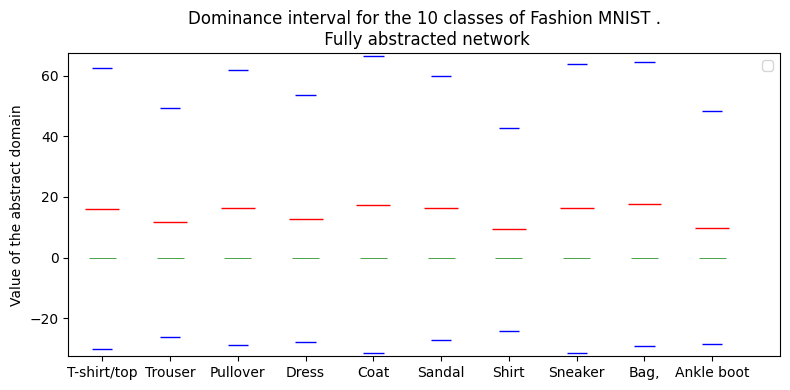

  2%|▎         | 30/1200 [15:48<9:00:50, 27.74s/it] /home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 34.86 %


  3%|▎         | 39/1200 [20:28<10:30:41, 32.59s/it]

Update parameter after EPOCH
EPOCH ACCURACY = 34.86 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.72 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.84 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.92 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.73 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.63 %
Update parameter after EPOCH
EPOCH ACCURACY = 34.46 %


  3%|▎         | 40/1200 [21:16<11:56:34, 37.06s/it]

EPOCH ACCURACY = 35.03 %
new seed generated with accuracy  tensor(35.0300)
New exploration domain with scale  = 0.005 ; noise ! = 0.15
EPOCH ACCURACY = 35.03 %


  4%|▎         | 42/1200 [22:22<11:02:48, 34.34s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


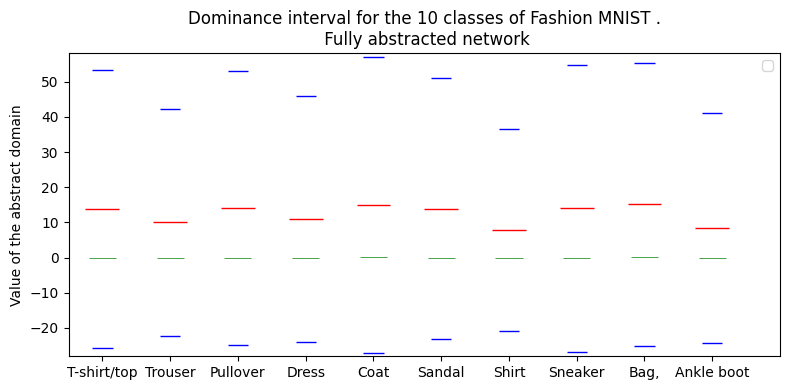

  4%|▍         | 46/1200 [24:23<10:11:58, 31.82s/it]


KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
from common import make_indice_and_values_tupple,plot_dominance
abstract_network = True
random__image_select = True
model = AbstractNN()
#model.load_state_dict(torch.load('model_first_step3627.pth'))
#model.load_state_dict(torch.load('modelseeds.pth'))
"""
Xperience over sparse initialisation
for param in model.parameters():
    param.data = torch.zeros_like(param.data)
for param in model.parameters():
    shape = param.data.shape
    tensor = torch.zeros(shape)
    num_elements = tensor.numel()
    num_random_elements = int(0.5 * num_elements)
    random_indices = np.random.choice(num_elements, num_random_elements, replace=False)
    random_values = 1/num_class*torch.randn(num_random_elements)
    multi_dim_indices = np.unravel_index(random_indices, tensor.shape)
    tensor[multi_dim_indices] = random_values
    param.data =tensor
    """

xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []

best_model_wts = None
best_acc    = 0
best_epoch_indice = 0

scale_init      = 0.005
noise_init      = 0.15
noise           = noise_init
scale           = scale_init
epoch_acc       = 0
       
num_class       = 10
batch_size      = 10
for i in tqdm(range(1200)):
    if i%num_class==0:
        eval =CT(model, device = device)
        eval.evaluate_model(dataset_test)
 
   
   
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

    if random__image_select:
        while label!= i%num_class: 
            index = np.random.randint(0,5000)
            
            img, label = dataset_train[index]
    else :
        index = 0
        while label!= i%num_class:
            img, label = dataset_train[index]
            index+=1

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =noise*torch.ones(28*28))
    x=x.abstract_tensor()


    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    random_plot = np.random.randint(num_class)
    if random_plot==1:
        plot_dominance(result,x_min,x_max,x_true)



    concatenated_heatmap_tensors =[]
    for j in range(num_class):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(num_class,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

  
    k_plus = 0.9*num_class/batch_size

    k_min = k_plus/9

    
   
    if ((i+1)%batch_size)==0 :
        while epoch_acc>= best_acc*0.99:
            print(f"Update parameter after EPOCH")
            for k in range (num_class):
                model.conv1.weight.data =model.conv1.weight.data + k_plus*(conv1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data + k_plus*(conv2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc1[1].weight.data =model.fc1[1].weight.data + k_plus*(fc1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc2[1].weight.data =model.fc2[1].weight.data + k_plus*(fc2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.no
          
            from custom_train import CustomTrainer as CT
            eval =CT(model, device = device)
            epoch_acc = eval.evaluate_model(dataset_test)
            if  epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_epoch_indice = i
                        best_model_wts = copy.deepcopy(model.state_dict())
                        
       
        
        model.load_state_dict(best_model_wts)
        model2 = AbstractNN()
        for param,param2 in zip(model.parameters(),model2.parameters()):
            param.data += 0.01*param2.data

        best_acc =CT(model,device = device).evaluate_model(dataset_test)
        epoch_acc=best_acc
        print("new seed generated with accuracy ", best_acc)
        if ((i+1)%batch_size==0):
            scale = scale_init/(int((i+1)/batch_size))
            noise = noise_init/(int((i+1)/batch_size))
            print(f'New exploration domain with scale  = {scale} ; noise ! = {noise}')
        batch_size+=batch_size
        
        
    


    

In [128]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
from common import make_indice_and_values_tupple,plot_dominance
abstract_network = True
random__image_select = True
model = AbstractNN()
#model.load_state_dict(torch.load('model_first_step3627.pth'))
#model.load_state_dict(torch.load('modelseeds.pth'))
"""
for param in model.parameters():
    param.data = torch.zeros_like(param.data)

for param in model.parameters():
    shape = param.data.shape
    tensor = torch.zeros(shape)
    num_elements = tensor.numel()
    num_random_elements = int(0.5 * num_elements)
    random_indices = np.random.choice(num_elements, num_random_elements, replace=False)
    random_values = 1/num_class*torch.randn(num_random_elements)
    multi_dim_indices = np.unravel_index(random_indices, tensor.shape)
    tensor[multi_dim_indices] = random_values
    param.data =tensor
    
"""
xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []

best_model_wts = None
best_acc    = 0
best_epoch_indice = 0

scale_init      = 0.01
noise_init      = 0.15
noise           = noise_init
scale           = scale_init
epoch_acc       = 0
       
num_class       = 10
batch_size      = 10
for i in tqdm(range(1200)):
    if i%num_class==0:
        eval =CT(model, device = device)
        eval.evaluate_model(dataset_test)
 
   
   
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

    if random__image_select:
        while label!= i%num_class: 
            index = np.random.randint(0,5000)
            
            img, label = dataset_train[index]
    else :
        index = 0
        while label!= i%num_class:
            img, label = dataset_train[index]
            index+=1

    #name_label_list.append(xticklabels[label])
    #num_label_list.append(label)
   
    #img_list.append(img)
    
    x=AT(img,alpha =noise*torch.ones(28*28))
    x=x.abstract_tensor()


    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    #result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    #true_predict_list.append(torch.argmax(x_true))
    random_plot = np.random.randint(num_class)
    if random_plot==1:
        plot_dominance(result,x_min,x_max,x_true)



    concatenated_heatmap_tensors =[]
    for j in range(num_class):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

   # img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(num_class):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(num_class,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(num_class):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

  



    
  
    if ((i+1)%batch_size)==0 :
        max_iter = 20
        iter = 0
        eval =CT(model, device = device)
        epoch_acc = eval.evaluate_model(dataset_test)
        best_acc = epoch_acc
        while (iter<10) or ((epoch_acc>= best_acc*0.99)and(iter<max_iter)):
            iter=+1
            print(f"Epoch acc = {epoch_acc}")
            print(f"best_acc={best_acc}")
            print(f'iter={iter}')
            
            print(f"Update parameter after EPOCH")
            conv1_w_sgn = 0
            conv1_b_sgn = 0
            conv2_w_sgn = 0
            conv2_b_sgn = 0
            fc1_w_sgn   = 0
            fc1_b_sgn   = 0
            fc2_w_sgn   = 0
            fc2_b_sgn   = 0
            for k in range(num_class):

                conv1_w_sgn += k_plus*(conv1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                conv1_b_sgn += k_plus*(conv1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                conv2_w_sgn += k_plus*(conv2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                conv2_b_sgn += k_plus*(conv2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                fc1_w_sgn   += k_plus*(fc1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                fc1_b_sgn   += k_plus*(fc1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                fc2_w_sgn   += k_plus*(fc2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                fc2_b_sgn   += k_plus*(fc2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.no

            model.conv1.weight.data    += torch.sign(conv1_w_sgn)*scale*0.1
            model.conv2.weight.data    += torch.sign(conv2_w_sgn)*scale*0.1
            model.conv1.bias.data      += torch.sign(conv1_b_sgn)*scale*0.1
            model.conv2.bias.data      += torch.sign(conv2_b_sgn)*scale*0.1
            model.fc1[1].weight.data   += torch.sign(fc1_w_sgn)*scale*0.1
            model.fc1[1].bias.data     += torch.sign(fc1_b_sgn)*scale*0.1
            model.fc2[1].weight.data   += torch.sign(fc2_w_sgn)*scale*0.1
            model.fc2[1].bias.data     += torch.sign(fc2_b_sgn)*scale*0.1


            from custom_train import CustomTrainer as CT

            
         
         
            eval =CT(model, device = device)
            epoch_acc = eval.evaluate_model(dataset_test)
            if  epoch_acc >= best_acc:
                        best_acc = epoch_acc
                        best_epoch_indice = i
                        best_model_wts = copy.deepcopy(model.state_dict())
        
        model.load_state_dict(best_model_wts) 
        #Robin Monroe condition for convergence///
        scale = scale_init/(int((i+1)/batch_size))
                
                
    



  0%|          | 0/1200 [00:00<?, ?it/s]/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH ACCURACY = 9.39 %


  1%|          | 7/1200 [03:29<10:00:51, 30.22s/it]

In [127]:
epoch_acc

tensor(10.)

In [126]:
eval.evaluate_model(dataset_test)

EPOCH ACCURACY = 23.55 %


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(23.5500)

In [123]:
best_acc

tensor(23.5500)

In [122]:
epoch_acc

tensor(10.)

In [106]:
model.fc1[1].bias.data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
model_ = copy.deepcopy(model.state_dict())

In [125]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [102]:
k_plus=1
k_min = 1/9

print(f"Update parameter after EPOCH")
conv1_w_sgn = torch.zeros_like(model.conv1.weight.data)
conv1_b_sgn = torch.zeros_like(model.conv1.bias.data)
conv2_w_sgn = torch.zeros_like(model.conv2.weight.data)
conv2_b_sgn = torch.zeros_like(model.conv2.bias.data)
fc1_w_sgn   = 0
fc1_b_sgn   = 0
fc2_w_sgn   = 0
fc2_b_sgn   = 0
for k in range (num_class):






    conv1_w_sgn += k_plus*(conv1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
    conv1_b_sgn += k_plus*(conv1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

    conv2_w_sgn += k_plus*(conv2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(conv2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
    conv2_b_sgn += k_plus*(conv2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(conv2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(conv2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

    fc1_w_sgn   += k_plus*(fc1_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc1_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
    fc1_b_sgn   += k_plus*(fc1_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc1_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc1_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

    fc2_w_sgn   += k_plus*(fc2_weight_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_weight_relevance_list[-num_class+k][:k%num_class],dim =0)+torch.sum(fc2_weight_relevance_list[-num_class+k][(k+1)%num_class:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
    fc2_b_sgn   += k_plus*(fc2_bias_relevance_list[-batch_size+k][k%num_class])-k_min*(torch.sum(fc2_bias_relevance_list[-num_class+k][:k%num_class],dim = 0)+torch.sum(fc2_bias_relevance_list[-num_class+k][(k+1)%num_class:],dim = 0))#/torch.no

model.conv1.weight.data += torch.sign(conv1_w_sgn)*scale
model.conv2.weight.data += torch.sign(conv2_w_sgn)*scale
model.conv1.bias.data += torch.sign(conv1_b_sgn)*scale
model.conv2.bias.data += torch.sign(conv2_b_sgn)*scale
model.fc1[1].weight.data += torch.sign(fc1_w_sgn)*scale
model.fc1[1].bias.data += torch.sign(fc1_b_sgn)*scale
model.fc2[1].weight.data += torch.sign(fc2_w_sgn)*scale
model.fc2[1].bias.data += torch.sign(fc2_b_sgn)*scale


from custom_train import CustomTrainer as CT
best_acc = epoch_acc
best_epoch_indice = i
best_model_wts = copy.deepcopy(model.state_dict())
eval =CT(model, device = device)
epoch_acc = eval.evaluate_model(dataset_test)
if  epoch_acc > best_acc:
            best_acc = epoch_acc
            best_epoch_indice = i
            best_model_wts = copy.deepcopy(model.state_dict())

Update parameter after EPOCH
EPOCH ACCURACY = 19.54 %


In [99]:
torch.sign(fc1_b_sgn)

tensor([-1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
        -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         1., -1.,  1.,  1.,  1.,  1., -1.,  1.])

In [61]:

import cvxpy as cp
import numpy as np

# Supposons que U soit une matrice de taille m x n
U = np.random.randn(10,150351)

# La taille de A est alors n x m pour obtenir une identité m x m
n, m = U.shape

# Variable de décision A de taille n x m
A = cp.Variable((m))

# Matrice identité
I = np.array([1,0,0,0,0,0,0,0,0,0])

# Formulation du problème
objective = cp.Minimize(cp.norm(U @ A - I, 'fro'))
constraints = [A >= -1, A <= 1]

# Problème d'optimisation
prob = cp.Problem(objective, constraints)

# Résolution
prob.solve()

# Solution obtenue
A_optimal = A.value

print("Matrice A optimale :")
print(A_optimal)


Matrice A optimale :
[ 1.12459623e-05  1.06451370e-05  7.02759216e-06 ...  3.98898875e-06
  1.02558290e-05 -9.86563286e-06]


In [77]:
import numpy as np
from scipy.optimize import minimize

# Création de 10 matrices U de dimension 10 x m
m = 100  # Par exemple, m est 5
U_list = [np.random.randn(10, m) for _ in range(10)]

# Création des vecteurs cibles (one-hot vectors)
targets = 10*np.eye(10)

# Fonction objectif à minimiser
def objective(A, U_list, targets):
    total_error = 0
    for i, U in enumerate(U_list):
        projection = U @ A
        error = np.linalg.norm(projection - targets[i])
        total_error += error
    return total_error

# Contraintes : 0 <= A_i <= 1
bounds = [(0, 1) for _ in range(m)]

# Initialisation de A
A0 = np.random.rand(m)

# Résolution du problème d'optimisation
result = minimize(objective, A0, args=(U_list, targets), method='SLSQP', bounds=bounds)

# Résultat optimal pour A
A_optimal = result.x

print("Vecteur A optimal :")
print(A_optimal)

# Vérification du résultat pour chaque matrice U_i
for i, U in enumerate(U_list):
    print(f"\nProjection de U_{i+1} * A :")
    print(U @ A_optimal)
    print(f"Vecteur cible :")
    print(targets[i])
    print(f"Différence :")
    print(U @ A_optimal - targets[i])

Vecteur A optimal :
[2.20840214e-14 1.96820332e-13 2.23876296e-13 7.33355413e-14
 4.76504784e-01 5.53325036e-02 1.81365030e-01 2.29596393e-01
 1.12329017e-01 3.11546484e-13 7.65924482e-01 4.37838328e-14
 4.39138644e-01 5.52432496e-01 6.31565148e-01 5.56923389e-14
 1.59283398e-01 2.44915075e-13 6.60452670e-03 4.65751046e-01
 7.15717579e-01 5.48297539e-01 1.17798115e-01 1.65231576e-13
 5.18459070e-01 8.02955443e-01 2.43743628e-01 5.22837372e-14
 4.39152853e-13 6.37415927e-02 1.45790562e-01 1.38974663e-13
 3.86920379e-14 3.82309502e-01 2.04524779e-13 1.52641581e-13
 1.20926885e-14 8.25609191e-14 3.52002691e-01 3.02226548e-13
 2.23495431e-13 2.33260045e-01 3.12394403e-01 1.19308135e-01
 9.81851510e-14 7.53498267e-02 3.84870892e-14 3.83585870e-01
 5.18329088e-14 1.05010101e-13 6.55445725e-14 2.40088551e-13
 4.24378976e-01 2.00859904e-01 4.57955997e-01 9.63897858e-02
 2.92786169e-13 1.38015911e-01 1.05639214e-13 3.95704075e-15
 5.84338369e-01 1.35545629e-01 1.82804820e-14 3.11335229e-13
 3.2

In [73]:
import numpy as np
from scipy.optimize import linprog

# Création de 10 matrices U de dimension 10 x m
m = 50  # Par exemple, m est 5
n = 10
U_list = [np.random.randn(n, m) for _ in range(10)]

# Création des vecteurs cibles (one-hot vectors)
targets = 100*np.eye(n)

# Nombre total de variables : m variables pour A et n variables pour les écarts absolus pour chaque U_i
num_vars = m + n * 10

# Fonction coût : minimiser la somme des écarts absolus
c = np.zeros(num_vars)
c[m:] = 1

# Matrice des contraintes
A_eq = []
b_eq = []

# Contraintes pour chaque U_i et vecteur cible
for i in range(10):
    U = U_list[i]
    target = targets[i]
    
    # Contraintes pour les écarts positifs
    for j in range(n):
        constraint = np.zeros(num_vars)
        constraint[:m] = U[j, :]
        constraint[m + i * n + j] = -1
        A_eq.append(constraint)
        b_eq.append(target[j])
        
    # Contraintes pour les écarts négatifs
    for j in range(n):
        constraint = np.zeros(num_vars)
        constraint[:m] = -U[j, :]
        constraint[m + i * n + j] = -1
        A_eq.append(constraint)
        b_eq.append(-target[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Contraintes de bornes pour A (0 <= A_i <= 1)
bounds = [(0, 1)] * m + [(0, None)] * (n * 10)

# Résolution du problème d'optimisation
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')

# Extraction du vecteur A optimal
A_optimal = result.x[:m]

print("Vecteur A optimal :")
print(A_optimal)

# Vérification du résultat pour chaque matrice U_i
for i, U in enumerate(U_list):
    projection = U @ A_optimal
    target = targets[i]
    print(f"\nProjection de U_{i+1} * A :")
    print(projection)
    print(f"Vecteur cible :")
    print(target)
    print(f"Différence :")
    print(projection - target)

Vecteur A optimal :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Projection de U_1 * A :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Vecteur cible :
[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Différence :
[-100.    0.    0.    0.    0.    0.    0.    0.    0.    0.]

Projection de U_2 * A :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Vecteur cible :
[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
Différence :
[   0. -100.    0.    0.    0.    0.    0.    0.    0.    0.]

Projection de U_3 * A :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Vecteur cible :
[  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
Différence :
[   0.    0. -100.    0.    0.    0.    0.    0.    0.    0.]

Projection de U_4 * A :
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Vecteur cible :
[  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
Différence :
[   0.    0.    0. -100.    0.    0.    0.    0.    0.    0.]

Projection de U_5 * A :
[

/tmp/ipykernel_833208/3013276635.py:51: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')
/tmp/ipykernel_833208/3013276635.py:51: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')


In [75]:
U

array([[ 7.76511950e-01, -2.11416600e-01, -8.16243363e-01,
         6.15934802e-01, -7.77046502e-02, -9.34587149e-01,
        -1.14191775e+00,  1.20720608e+00, -6.02142752e-01,
        -2.35146094e-01, -1.88232421e+00, -2.91452421e-01,
         1.27163823e+00,  2.26413561e-02,  2.68831305e-01,
        -7.96448349e-01,  2.08628308e-01,  6.49565394e-01,
         4.87050819e-01, -5.06111662e-01,  1.05199116e+00,
        -5.74469085e-01, -2.24595320e-01, -8.07182156e-01,
         1.01983793e+00,  2.06280563e-01,  8.93093458e-01,
        -1.20618621e+00, -5.10572517e-01,  7.64116964e-01,
        -7.46463036e-01, -8.32280708e-01, -4.09005379e-01,
         1.62221128e-01,  4.29375485e-01,  8.15972888e-01,
        -6.47535372e-01,  6.20811166e-01, -4.51398384e-01,
         1.36317571e+00, -2.96390139e-01, -6.22422725e-01,
        -6.40961096e-01,  1.20690845e-01,  2.00782351e+00,
         2.04628008e-01,  8.24667789e-02, -7.33323936e-01,
         3.30273306e-01,  8.28059933e-01],
       [ 3.42

In [66]:
max(A_optimal)

2.5170101894250237e-05

In [65]:
print(U[:,0])

[ 1.59622766 -0.42862753 -0.62410684  0.0970611   0.22743921  0.67223485
 -1.11070654  0.70468959 -1.32805413 -1.6862091 ]


In [63]:
print(U@A_optimal)

[ 1.00000000e+00 -7.45388994e-18 -9.97465999e-18 -1.08420217e-19
 -3.03576608e-18  2.03830008e-17  1.15738582e-17  2.01661604e-17
 -5.76795556e-17  1.95156391e-17]


In [57]:

import numpy as np
from scipy.optimize import minimize

U_list = [np.random.randn(10, 123) for _ in range(10)]
S_list = [np.random.randn(10, 10) for _ in range(10)]


m, n = U_list[0].shape

def objective(A_vec, U_list, S_list, m, n):
    A = A_vec.reshape((n, m))
    total_error = 0
    for U, S in zip(U_list, S_list):
        total_error += np.linalg.norm(U @ A - S, 'fro')
    return total_error

# Contraintes : -1 <= A_ij <= 1
bounds = [(-1, 1) for _ in range(n * m)]

# Initialisation de A
A0 = np.zeros(n * m)

# Résolution du problème d'optimisation
result = minimize(objective, A0, args=(U_list, S_list, m, n), method='SLSQP', bounds=bounds)

# Résultat optimal pour A
A_optimal = result.x.reshape((n, m))

print("Matrice A optimale :")
print(A_optimal)

Matrice A optimale :
[[-0.32726402 -0.05483811 -0.27008309 ...  0.00894211 -0.01061029
  -0.0656751 ]
 [-0.17004817 -0.13314101  0.07450138 ... -0.20929294  0.35085373
   0.10897319]
 [ 0.06524285  0.03585318  0.01339497 ... -0.07603262 -0.04163731
   0.21987791]
 ...
 [-0.21831855 -0.52682855 -0.05274236 ...  0.01596774  0.06934764
  -0.25794054]
 [-0.34488701 -0.30493354 -0.00435956 ...  0.06364987  0.08555236
   0.19018415]
 [-0.19105156  0.44460304 -0.05878165 ... -0.29982517  0.09671853
   0.21287517]]


In [58]:
str = 'test'
str2 = 'test2'

dictionaire = {str :3, str2: 4}

In [60]:
dictionaire['test']

3

In [49]:
U@A_optimal

array([[ 1.00000000e+01, -3.87060176e-17,  6.91720986e-17,
        -4.87890978e-19, -8.51098705e-18,  2.52293846e-16,
        -3.28513258e-17,  1.56287743e-16, -1.99818460e-16,
        -1.37693676e-17],
       [-7.69783542e-18,  1.00000000e+01, -2.08112607e-16,
         1.23273787e-16,  7.23162849e-17,  9.75781955e-17,
         5.02527707e-17,  2.06865775e-16, -1.22514845e-16,
        -2.86771475e-17],
       [-5.94142791e-17,  2.30935063e-17,  1.00000000e+01,
        -1.12214925e-16, -4.33680869e-19, -5.44269491e-17,
        -1.19533290e-17, -5.22368607e-16, -1.30971622e-16,
        -4.60785923e-17],
       [ 1.14356224e-16, -2.85307802e-16, -7.13405029e-17,
         1.00000000e+01,  3.21574364e-16, -2.81025203e-16,
         7.77372958e-17, -1.62088225e-16,  1.90114851e-16,
         3.49655201e-16],
       [-1.27122705e-17, -1.31188463e-16, -3.34801631e-16,
        -2.71050543e-17,  1.00000000e+01, -2.71917905e-16,
         2.61292724e-17, -2.98697699e-17,  1.34115809e-16,
         5.

In [ ]:
eval =CT(model,device).evaluate()



In [ ]:
result[784:784+784,2]


In [32]:

k_plus = 0.2
epoch_acc = best_acc

while epoch_acc>= best_acc:
        for k in range (10):
                print((torch.sum(conv1_weight_relevance_list[-50+k][:k%10],dim = 0).shape))
                model.conv1.weight.data =model.conv1.weight.data + k_plus*(conv1_weight_relevance_list[-50+k][k%10])-k_min*(torch.sum(conv1_weight_relevance_list[-50+k][:k%10],dim =0)+torch.sum(conv1_weight_relevance_list[-50+k][(k+1)%10:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-50+k][k%10])-k_min*(torch.sum(conv1_bias_relevance_list[-50+k][:k%10],dim = 0)+torch.sum(conv1_bias_relevance_list[-50+k][(k+1)%10:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-50+k][k%10])-k_min*(torch.sum(conv2_weight_relevance_list[-50+k][:k%10],dim =0)+torch.sum(conv2_weight_relevance_list[-50+k][(k+1)%10:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-50+k][k%10])-k_min*(torch.sum(conv2_bias_relevance_list[-50+k][:k%10],dim = 0)+torch.sum(conv2_bias_relevance_list[-50+k][(k+1)%10:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))
        
        
                model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-50+k][k%10])-k_min*(torch.sum(fc1_weight_relevance_list[-50+k][:k%10],dim =0)+torch.sum(fc1_weight_relevance_list[-50+k][(k+1)%10:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-50+k][k%10])-k_min*(torch.sum(fc1_bias_relevance_list[-50+k][:k%10],dim = 0)+torch.sum(fc1_bias_relevance_list[-50+k][(k+1)%10:],dim = 0))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))
        
                model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-50+k][k%10])-k_min*(torch.sum(fc2_weight_relevance_list[-50+k][:k%10],dim =0)+torch.sum(fc2_weight_relevance_list[-50+k][(k+1)%10:],dim =0))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
        
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-50+k][k%10])-k_min*(torch.sum(fc2_bias_relevance_list[-50+k][:k%10],dim = 0)+torch.sum(fc2_bias_relevance_list[-50+k][(k+1)%10:],dim = 0))#/torch.no
        
        


        from custom_train import CustomTrainer as CT
        print(f"Update parameter after EPOCH {i%50}")
        eval =CT(model, device = device)
        epoch_acc = eval.evaluate_model(dataset_test)
        if  epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch_indice = i
                best_model_wts = copy.deepcopy(model.state_dict())

torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
torch.Size([16, 1, 3, 3])
Update parameter after EPOCH 49
EPOCH ACCURACY = 10.00 %


In [ ]:
fc= torch.zeros_like(model.fc1[1].weight.data)
k_min=k_plus
for k in range(10):
    
    fc+=k_plus*(fc1_weight_relevance_list[-10+k][k])-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0))#
plt.imshow(torch.abs(fc[:,4600:4650]))
plt.colorbar()

In [ ]:
model.conv1.weight.data

In [ ]:
torch.max(conv1_weight_relevance_list[9][8])

In [ ]:
plt.imshow(fc2_weight_relevance_list[5][6][:,:])
plt.colorbar()

In [ ]:
best_acc

In [ ]:
i = 9
((i+1)%10) 

In [ ]:
test = []
for i in range(10):
    test.append(i)

for k in range(10):
    print(test[-10+k],k)

In [ ]:
result = result_list[1]
plot_dominance(*result[:4])

In [ ]:

concat= torch.abs(img_relevance_list[0][2])

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(fc1_weight_relevance_list[0][1,:,200:400]))




In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(12, 6)) 
plt.imshow(torch.abs(model.fc1[1].weight.data[:,200:400]))

In [ ]:
label_list_number = np.arange(0,50,1)
label_list_number = np.array([int(label_list_number[i]/10) for i in label_list_number])

In [ ]:
label_list_number

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(3, 2, figsize = (12, 12),gridspec_kw={'width_ratios': [1,3],'height_ratios': [1, 1, 2]})
def init():
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[0][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400]))
    ax[1,0].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    ax[1,1].imshow(np.abs(array_list_fc1[0][label_list_number[0],:,200:400]))
   
    result,y_min,y_max,y_true = result_list[0][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[2,0].axis('off')
  
    
 
    return [ax]

def update(frame):
    
    ax[2,1].cla()
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[frame][0])
    ax[0,1].imshow(np.abs(model.fc1[1].weight.data[:,200:400+2*frame]))
    ax[1,0].imshow(np.abs(img_relevance_list[frame][num_label_list[frame]].reshape(28,28)))
   

    ax[1,1].imshow(np.abs(array_list_fc1[frame][num_label_list[frame],:,200:400]))
    result,y_min,y_max,y_true = result_list[frame][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:
    ax[2,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    
    ax[2,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[2,1].plot([num_label_list[frame], num_label_list[frame]], [y_min[num_label_list[frame]], y_max[num_label_list[frame]]], color='red') 
    ax[2,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[2,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    
    ax[2,0].axis('off')


    plt.title(f'Inference over {name_label_list[frame]} ; Relevance of fc1 layer IAW {label_list_number[frame]} label.')

    return [ax]


animation = FuncAnimation(fig, update, frames=50, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [ ]:

array = torch.randn(3,3,3)
array

In [ ]:
array[0][2]

In [ ]:
import pickle
total_list = [img_list,
img_relevance_list,
conv1_weight_relevance_list, 
conv1_bias_relevance_list,
conv2_weight_relevance_list,
conv2_bias_relevance_list, 

fc1_weight_relevance_list, 
fc1_bias_relevance_list, 
fc2_weight_relevance_list, 
fc2_bias_relevance_list,  
result_list,
num_label_list,
name_label_list, 
true_predict_list] 


file_path = 'my_list.pkl'


with open(file_path, 'wb') as file:
 
    pickle.load(total_list, file)

In [ ]:

import pickle
file_path = 'my_list.pkl'


with open(file_path, 'rb') as file:
 
    pickle.load(file)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(1, 2, figsize = (12, 6),gridspec_kw={'width_ratios': [1,1]})
def init():
  
   
    ax[0].imshow(array_list_img[0][0])

    ax[1].imshow(np.abs(img_relevance_list[0][0].reshape(28,28)))

    
  
    
 
    return [ax]

def update(frame):
    
  
   
    ax[0].imshow(array_list_img[frame+20][0])

    ax[1].imshow(np.abs(img_relevance_list[frame+20][num_label_list[frame+20]].reshape(28,28)))
   






    return [ax]


animation = FuncAnimation(fig, update, frames=20, init_func=init)

output_video = 'Abstract_network_relevance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
abstract_network = False
scale =0.01
xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []




for i in tqdm(range(10)):
    print(i)
    if i%10 ==0:
        scale = 0.01/(i/10+1)
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*conv1__weight_span*torch.ones_like(conv1_eps_weight.indices)
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*conv1__bias_span*torch.ones_like(conv1_eps_bias.indices)


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*conv2_weight_span*torch.ones_like(conv2_eps_weight.indices)
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale/2*conv2_bias_span*torch.ones_like(conv2_eps_bias.indices)

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale/1*fc1_weight_span*torch.ones_like(fc1_eps_weight.indices)
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale/1*fc1_bias_span*torch.ones_like(fc1_eps_bias.indices)


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale/100*fc2_weight_span*torch.ones_like(fc2_eps_weight.indices)
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale/100*fc2_bias_span*torch.ones_like(fc2_eps_bias.indices)


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        
        for param in model.named_parameters():
            if param[0] == 'fc1.1.weight':
                    print(torch.sum(param[1].data))        
                    index = torch.topk(torch.abs(param[1].data).flatten(),k=294912,largest=False)
                    mat= param[1].data
            

                    alpha= 1.1*torch.abs(index.values)

        fc1_eps_bias = make_indice_and_values_tupple()
        
        fc1_eps_weight = make_indice_and_values_tupple()
        fc1_eps_weight.indices = index.indices
        fc1_eps_weight.values = alpha
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

  
    while label!= i: 
        index = np.random.randint(0,5000)
        
        img, label = dataset_train[index]

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =torch.tensor([]))
    x=x.abstract_tensor()
    print(x.shape)

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    plot_dominance(result,x_min,x_max,x_true)
    


    concatenated_tensors = []
    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


        conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
        conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
        conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

        conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

        fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
        fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
        fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
        fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

    else :
        fc1_bias_concatenated_tensors =[]
        fc1_weight_concatenated_tensors = []
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j]#.reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)


    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)

    """
    k_min = 0.01
    k_plus = 0.6
    if i>9:
        k_plus = 0.5
        k_min = 0.05
    if i>19:
        k_plus = 0.4
        k_min = 0.1
    if i>39:
        k_min = 0.2
    """
    
    """
    model.conv1.weight.data =model.conv1.weight.data+k_plus*(concatenated_tensors[label]-k_min*(torch.sum(concatenated_tensors[:label],dim =0)+torch.sum(concatenated_tensors[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv1.bias.data = model.conv1.bias.data + k_plus*(concatenated_bias_tensors[label]-k_min*(torch.sum(concatenated_bias_tensors[:label],dim = 0)+torch.sum(concatenated_bias_tensors[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.conv2.weight.data =model.conv2.weight.data+k_plus*(concatenated_tensors_2[label]-k_min*(torch.sum(concatenated_tensors_2[:label],dim =0)+torch.sum(concatenated_tensors_2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.conv2.bias.data = model.conv2.bias.data + k_plus*(concatenated_bias_tensors_2[label]-k_min*(torch.sum(concatenated_bias_tensors_2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_2[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(concatenated_tensors_fc1[label]-k_min*(torch.sum(concatenated_tensors_fc1[:label],dim =0)+torch.sum(concatenated_tensors_fc1[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(concatenated_bias_tensors_fc1[label]-k_min*(torch.sum(concatenated_bias_tensors_fc1[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc1[label+1:],dim = 0)))#/torch.norm(2*concatenated_bias_tensors[label]-torch.sum(concatenated_bias_tensors,dim = 0))

    model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(concatenated_tensors_fc2[label]-k_min*(torch.sum(concatenated_tensors_fc2[:label],dim =0)+torch.sum(concatenated_tensors_fc2[label+1:],dim =0)))#/torch.norm(2*concatenated_tensors[label]-torch.sum(concatenated_tensors,dim =0))
    model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(concatenated_bias_tensors_fc2[label]-k_min*(torch.sum(concatenated_bias_tensors_fc2[:label],dim = 0)+torch.sum(concatenated_bias_tensors_fc2[label+1:],dim = 0)))#/torch.no
    """
   

   
    

    

In [ ]:
model.load_state_dict(torch.load('dataset/FMNIST.pth'))
from custom_train import CustomTrainer as CT


In [ ]:

eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

In [ ]:
map_relevance = torch.zeros_like(mat).flatten()
map_original = torch.zeros_like(mat).flatten() 
print(fc1_weight_relevance_list[0][0].shape)
map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
map_relevance = map_relevance.reshape(mat.shape)
map_original = map_original.reshape(mat.shape)
print(f"map_2.shape = {map_relevance.shape}")

map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


In [ ]:
print(map_normalized_relevance.shape)

In [ ]:
map_total_normalised_relevance = []
for i in range(100):
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 

    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
  

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)
    print(torch.min(map_normalized_relevance))
    map_total_normalised_relevance.append(map_normalized_relevance)
map_total_normalised_relevance= torch.stack(map_total_normalised_relevance)
print(map_total_normalised_relevance.shape)
map_total_normalised_relevance = torch.sum(map_total_normalised_relevance, dim =0)
print(map_total_normalised_relevance.shape)



In [ ]:
print(torch.max(map_total_normalised_relevance))
mask =torch.where(map_total_normalised_relevance>5,1,0)
print(torch.sum(mask))
mask_1 = torch.ones_like(mask)
mask_1.flatten()[fc1_eps_weight.indices] = 0
print(torch.sum(mask_1))
mask_1 +=mask
print(torch.sum(mask_1))

model.fc1[1].weight.data *=mask_1

In [ ]:
torch.sum(mask_1)

plt.imshow

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

"""
This is the code to create a video of the prediction and the ground truth
It takes the prediction and the ground truth and reshapes them to the original shape of the image.
It then creates a video of the prediction and the ground truth.
"""


array_list_img=np.array(img_list)

array_list_fc1=np.array(fc1_weight_relevance_list)

fig, ax = plt.subplots(2, 2, figsize = (12, 12),gridspec_kw={'width_ratios': [1,3],'height_ratios': [1, 1.5]})
def init():

    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[0][0])
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 
    print(fc1_weight_relevance_list[0][0].shape)
    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[0][0]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
 

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


    ax[0,1].imshow(map_normalized_relevance[:,200:400])



    result,y_min,y_max,y_true = result_list[0][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[1,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[1,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[1,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[1,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[1,0].axis('off')
  
    
 
    return [ax]

def update(frame):
    ax[0,0].cla()
    ax[1,0].cla()
    ax[1,1].cla()
    ax[0,1].cla()
   
    ax[0,0].imshow(array_list_img[frame+20][0])
    map_relevance = torch.zeros_like(mat).flatten()
    map_original = torch.zeros_like(mat).flatten() 

    map_relevance[ fc1_eps_weight.indices]=  fc1_weight_relevance_list[frame+20][num_label_list[frame+20]]
    map_original[ fc1_eps_weight.indices]= mat.flatten()[ fc1_eps_weight.indices]
    map_relevance = map_relevance.reshape(mat.shape)
    map_original = map_original.reshape(mat.shape)
 

    map_normalized_relevance = torch.abs(map_relevance)/torch.abs(map_original)
    map_normalized_relevance = torch.where(torch.isnan(map_normalized_relevance), torch.zeros_like(map_normalized_relevance), map_normalized_relevance)


    ax[0,1].imshow(map_normalized_relevance[:,200:400])



    result,y_min,y_max,y_true = result_list[frame+20][:4]
    y_min       =  np.array(y_min)
    y_max       =  np.array(y_max)
    center_Ztp  =  np.expand_dims(np.array(result[0]),axis =1)
    y_true      =  np.expand_dims(np.array(y_true[:])[0],axis =1)



       




    x_scale = np.arange(len(y_min))
    D =np.stack((y_min,y_max),axis=1)

    
    # plot:

    
    ax[1,1].eventplot(D, orientation="vertical", linewidth=1,color='blue',linelengths=0.3)
    ax[1,1].eventplot(y_true, orientation="vertical", linewidth=0.50,color='green',linelengths=0.4)
    ax[1,1].eventplot(center_Ztp, orientation="vertical", linewidth=1,color='red',linelengths=0.5)

    ax[1,1].set(xlim=(-0.5, 10),xticks=x_scale,xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"],
            ylim=(np.min(D)-1, np.max(D)+1))
    ax[1,0].axis('off')
    
 

    return [ax]


animation = FuncAnimation(fig, update, frames=50, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [ ]:
x = np.random.randn(1000)
y = np.random.randn(1000)


In [ ]:
circle_center = (0, 0)
circle_radius = 0.8

# Création de la figure et de l'axe
fig, ax = plt.subplots()

# Scatter plot
ax.scatter(x, y)

# Création du cercle
circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

# Ajout du cercle à l'axe
ax.add_patch(circle)

# Définir les limites de l'axe pour s'assurer que le cercle est visible
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)


In [ ]:
x = np.random.randn(1000)
y = np.random.randn(1000)

x

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize = (12, 12))

x = np.random.randn(1000)
y = np.random.randn(1000)
x_red =[]
y_red =[]


def init():

    circle_center = (0, 0)
    circle_radius = 0.8

    # Création de la figure et de l'axe
    fig, ax = plt.subplots()

    # Scatter plot
    ax.scatter(x, y)

    # Création du cercle
    circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

    # Ajout du cercle à l'axe
    ax.add_patch(circle)

    # Définir les limites de l'axe pour s'assurer que le cercle est visible
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
 
    return [ax]

def update(frame):

    ax.scatter(x, y,color='blue')


    # Définir les limites de l'axe pour s'assurer que le cercle est visible
    circle = plt.Circle(circle_center, circle_radius, color='r', fill=False)

    # Ajout du cercle à l'axe
    ax.add_patch(circle)
  

    dist = np.sqrt(x**2+y**2)


    for el in np.random.randint(0,999,size=10):
        if dist[el]<0.8:
            x_red.append(x[el])
            y_red.append(y[el])
    ax.scatter(x_red, y_red,color = 'red')

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    return [ax]


animation = FuncAnimation(fig, update, frames=10, init_func=init)

output_video = 'Abstract_network_relevance_dominance.mp4'

animation.save(output_video, fps=0.5, extra_args=['-vcodec', 'libx264'])

In [ ]:
model = AbstractNN()
from custom_train import CustomTrainer as CT
print(f"Update parameter after EPOCH {i%10}")
eval =CT(model, device = device)
eval.evaluate_model(dataset_test)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from abstract import abstractTensor as AT
from common import make_indice_and_values_tupple,plot_dominance
abstract_network = True

xticklabels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag,","Ankle boot"]

img_list = []
img_relevance_list =[]
conv1_weight_relevance_list = []
conv1_bias_relevance_list = []
conv2_weight_relevance_list = []
conv2_bias_relevance_list = []

fc1_weight_relevance_list = []
fc1_bias_relevance_list = []
fc2_weight_relevance_list = []
fc2_bias_relevance_list  = []
result_list =[]
num_label_list = []
name_label_list = []
true_predict_list = []




for i in tqdm(range(500)):
 
   
    scale = 0.1
    if abstract_network : 
    
        conv1_eps_weight = torch.tensor([])
        conv1__weight_span = torch.max(model.conv1.weight.data.flatten())-torch.min(model.conv1.weight.data.flatten())
        conv1_eps_weight.indices = torch.arange(0,len(model.conv1.weight.data.flatten()),1)
        conv1_eps_weight.values = scale*model.conv1.weight.data.flatten()
        conv1_eps_bias = torch.tensor([])
        conv1__bias_span = torch.max(model.conv1.bias.data.flatten())-torch.min(model.conv1.bias.data.flatten())
        conv1_eps_bias.indices = torch.arange(0,len(model.conv1.bias.data.flatten()),1)
        conv1_eps_bias.values = scale*torch.ones_like(model.conv1.bias.data.flatten())


        conv2_eps_weight = torch.tensor([])
        conv2_eps_weight.indices = torch.arange(0,len(model.conv2.weight.data.flatten()),1)
        conv2_weight_span = torch.max(model.conv2.weight.data.flatten())-torch.min(model.conv2.weight.data.flatten())
        conv2_eps_weight.values = scale*model.conv2.weight.data.flatten()
        conv2_eps_bias = torch.tensor([])
        conv2_eps_bias.indices = torch.arange(0,len(model.conv2.bias.data.flatten()),1)
        conv2_bias_span = torch.max(model.conv2.bias.data.flatten())-torch.min(model.conv2.bias.data.flatten())
        conv2_eps_bias.values = scale*torch.ones_like(model.conv2.bias.data.flatten())

        fc1_eps_weight = torch.tensor([])
        fc1_weight_span = torch.max(model.fc1[1].weight.data.flatten())-torch.min(model.fc1[1].weight.data.flatten())
        fc1_eps_weight.indices = torch.arange(0,len(model.fc1[1].weight.data.flatten()),1)
        fc1_eps_weight.values = scale*model.fc1[1].weight.data.flatten()
        fc1_eps_bias = torch.tensor([])
        fc1_bias_span = torch.max(model.fc1[1].bias.data.flatten())-torch.min(model.fc1[1].bias.data.flatten())
        fc1_eps_bias.indices = torch.arange(0,len(model.fc1[1].bias.data.flatten()),1)
        fc1_eps_bias.values = scale*torch.ones_like(model.fc1[1].bias.data.flatten())


        fc2_eps_weight = torch.tensor([])
        fc2_weight_span = torch.max(model.fc2[1].weight.data.flatten())-torch.min(model.fc2[1].weight.data.flatten())
        fc2_eps_weight.indices = torch.arange(0,len(model.fc2[1].weight.data.flatten()),1)
        fc2_eps_weight.values = scale*model.fc2[1].weight.data.flatten()
        fc2_eps_bias = torch.tensor([])
        fc2_bias_span = torch.max(model.fc2[1].bias.data.flatten())-torch.min(model.fc2[1].bias.data.flatten())
        fc2_eps_bias.indices = torch.arange(0,len(model.fc2[1].bias.data.flatten()),1)
        fc2_eps_bias.values = scale*torch.ones_like(model.fc2[1].bias.data.flatten())


    else :
        conv1_eps_weight = make_indice_and_values_tupple()
        conv1_eps_bias = make_indice_and_values_tupple()
       

        conv2_eps_weight = make_indice_and_values_tupple()
        conv2_eps_bias = make_indice_and_values_tupple()
        fc1_eps_bias = make_indice_and_values_tupple()
        fc1_eps_weight = make_indice_and_values_tupple()
        fc2_eps_weight = make_indice_and_values_tupple()
        fc2_eps_bias = make_indice_and_values_tupple()




    label = None

  
    while label!= i%10: 
        index = np.random.randint(0,5000)
        
        img, label = dataset_train[index]

    name_label_list.append(xticklabels[label])
    num_label_list.append(label)
   
    img_list.append(img)
    
    x=AT(img,alpha =0.08*scale*torch.ones(28*28))
    x=x.abstract_tensor()
 

    
  
    with torch.no_grad():
      
        
        result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1=model.abstract_forward(x,
                                                                    conv1_eps_bias=conv1_eps_bias,
                                                                    conv1_eps_weight=conv1_eps_weight,
                                                                    conv2_eps_weight = conv2_eps_weight,
                                                                    conv2_eps_bias = conv2_eps_bias,

                                                                    fc1_eps_weight =fc1_eps_weight,
                                                                    fc1_eps_bias = fc1_eps_bias, 
                                                                    fc2_eps_weight = fc2_eps_weight,
                                                                    fc2_eps_bias = fc2_eps_bias,

                                                                    add_symbol=True)
        
    result_list.append([result,x_min,x_max,x_true,len_symb, len_symb_c2, len_symb_fc1])    
    true_predict_list.append(torch.argmax(x_true))
    if i%5==0:
        plot_dominance(result,x_min,x_max,x_true)
    


    concatenated_heatmap_tensors =[]
    for j in range(10):
        concat_part =result[1:785,j]
        concatenated_heatmap_tensors.append(concat_part)
    concatenated_heatmap_tensors = torch.stack(concatenated_heatmap_tensors)

    img_relevance_list.append(concatenated_heatmap_tensors)

  
    if abstract_network:

        conv1_weight_concatenated_tensors = []
        conv1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len(x)-1:len(x)+143, j].view(16, 1, 3, 3)
            conv1_weight_concatenated_tensors.append(concat_part)
        conv1_weight_concatenated_tensors =torch.stack(conv1_weight_concatenated_tensors)
        for j in range(10):
            concat_part= result[len(x)+143:len(x)+159, j]
            conv1_bias_concatenated_tensors .append(concat_part)
        conv1_bias_concatenated_tensors = torch.stack(conv1_bias_concatenated_tensors )

        conv2_weight_concatenated_tensors = []
        conv2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb-1:len_symb+4607, j].view(32, 16, 3, 3)
            conv2_weight_concatenated_tensors.append(concat_part)
        conv2_weight_concatenated_tensors =torch.stack(conv2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb+4607:len_symb+4639, j]
            conv2_bias_concatenated_tensors.append(concat_part)
        conv2_bias_concatenated_tensors = torch.stack(conv2_bias_concatenated_tensors)

        fc1_weight_concatenated_tensors = []
        fc1_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_c2-1:len_symb_c2+294911, j].reshape(64,4608)
            fc1_weight_concatenated_tensors.append(concat_part)
        fc1_weight_concatenated_tensors =torch.stack(fc1_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_c2+294911:len_symb_c2+294975, j]
            fc1_bias_concatenated_tensors.append(concat_part)
        fc1_bias_concatenated_tensors= torch.stack(fc1_bias_concatenated_tensors)

        fc2_weight_concatenated_tensors = []
        fc2_bias_concatenated_tensors =[]
        for j in range(10):
            concat_part = result[len_symb_fc1-1:len_symb_fc1+639, j].view(10,64)
            fc2_weight_concatenated_tensors.append(concat_part)
        fc2_weight_concatenated_tensors =torch.stack(fc2_weight_concatenated_tensors)
        for j in range(10):
            concat_part = result[len_symb_fc1+639:len_symb_fc1+649, j]
            fc2_bias_concatenated_tensors.append(concat_part)
        fc2_bias_concatenated_tensors= torch.stack(fc2_bias_concatenated_tensors)

    


    conv1_weight_relevance_list.append(conv1_weight_concatenated_tensors)
    conv1_bias_relevance_list.append(conv1_bias_concatenated_tensors)
    conv2_weight_relevance_list.append(conv2_weight_concatenated_tensors)

    conv2_bias_relevance_list.append(conv2_bias_concatenated_tensors)

    fc1_weight_relevance_list.append(fc1_weight_concatenated_tensors)
    fc1_bias_relevance_list.append(fc1_bias_concatenated_tensors)
    fc2_weight_relevance_list.append(fc2_weight_concatenated_tensors)
    fc2_bias_relevance_list.append(fc2_bias_concatenated_tensors)

  
    k_min = 0
    k_plus = 1

  
    if ((i+1)%10)==0 :
        print(f"Update parameter after EPOCH {i%10}")
        for k in range (10):
            model.conv1.weight.data =model.conv1.weight.data+k_plus*(conv1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

            model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
            model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.no
    
        from custom_train import CustomTrainer as CT
        print(f"Update parameter after EPOCH {i%10}")
        eval =CT(model, device = device)
        eval.evaluate_model(dataset_test)

    

In [ ]:
k_min = 0
k_plus = 100000000
for j in range(10):

    for k in range (10):
                model.conv1.weight.data =model.conv1.weight.data+k_plus*(conv1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv1.bias.data = model.conv1.bias.data + k_plus*(conv1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.conv2.weight.data =model.conv2.weight.data+k_plus*(conv2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(conv2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.conv2.bias.data = model.conv2.bias.data + k_plus*(conv2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(conv2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(conv2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc1[1].weight.data =model.fc1[1].weight.data+k_plus*(fc1_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc1_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc1[1].bias.data = model.fc1[1].bias.data + k_plus*(fc1_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc1_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc1_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.norm(2*conv1_bias_concatenated_tensors[label]-torch.sum(conv1_bias_concatenated_tensors,dim = 0))

                model.fc2[1].weight.data =model.fc2[1].weight.data+k_plus*(fc2_weight_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_weight_relevance_list[-10+k][:k],dim =0)+torch.sum(fc2_weight_relevance_list[-10+k][k+1:],dim =0)))#/torch.norm(2*conv1_weight_concatenated_tensors[label]-torch.sum(conv1_weight_concatenated_tensors,dim =0))
                model.fc2[1].bias.data = model.fc2[1].bias.data + k_plus*(fc2_bias_relevance_list[-10+k][k]-k_min*(torch.sum(fc2_bias_relevance_list[-10+k][:k],dim = 0)+torch.sum(fc2_bias_relevance_list[-10+k][k+1:],dim = 0)))#/torch.no
                print(torch.sum(conv1_weight_relevance_list[-10+k][k]))
    from custom_train import CustomTrainer as CT
    print(f"Update parameter after EPOCH {i%10}")
    eval =CT(model, device = device)
    eval.evaluate_model(dataset_test)


In [ ]:
print(torch.min(model.conv2.weight.data))